# Understanding the ROC Curve

The ROC (Receiver Operator Characteristic) Curve is a useful tool for understanding true and false positive rates for a classifier. I found this all simple and straightforward in theory, but a little trickier in the real world. Let's work through a simple example to understand the concept better.

Key Terms:
* **True Positive Rate**: the proportion of actual positives the model classifies as a positive.

*True Positive Rate = True Positives / (True Positives + False Negatives)*

* **False Positive Rate**: the proportion of actual negatives the model classifies as a positive.

*False Positive Rate = False Positives / (False Postivies + True Negatives)*
* **Threshold**: The level at which to deem an example a positive case.
* **Confusion Matrix**: A table indicating the true positives, true negatives, false positives and false negatives of a classifier.
* **Area Under the Curve (AUC)**: nice explanation found [here](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc#:~:text=AUC%3A%20Area%20Under%20the%20ROC,to%20(1%2C1).) "the probability that the model ranks a random positive example more highly than a random negative example"

For this example, we will use the [Wisconsin Breast Cancer]('https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html') dataset and a simple logistic regression model.

In [14]:
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, RocCurveDisplay,DetCurveDisplay, auc, PrecisionRecallDisplay
import matplotlib.pyplot as plt

## The Data
Here we have a simple binary classification problem based on a 1995 study of breast cancer. There are 2 classes: malignant and benign. For our purposes the "positive class" or class of interest is malignant. The negative class is benign.

In [2]:
# Data
data = load_breast_cancer()
print('The categories are {}'.format(list(data.target_names)))
X = data.data
y = data.target

# Let's make a test train split to better evaluate the model's performance on unseen data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('Number of train instances: ', len(y_train))
print('Number of features: ' , len(X_train[0]))

The categories are ['malignant', 'benign']
Number of train instances:  455
Number of features:  30


## Confusion Matrix
Before we dive in, let's review what a confusion matrix might look like for this problem. The bottom righthand hand box is true positives, or actual malignent examples our example correctly classifies as malignent. Similarly, the upper lefthand box are begnign examples that the model correctly classifies as begnign. The remaining two boxes are interesting. The first is false positive - or a benign example the model has incorrectly classified as a malignant one. The second is a false negative, or a malignant example the model has incorrely classified as benign. Likely in this scenario we are more concerned with false negatives than false positives, as the risks of misdiagnosis are much more severe if a true malignancy is missed than the other way round.

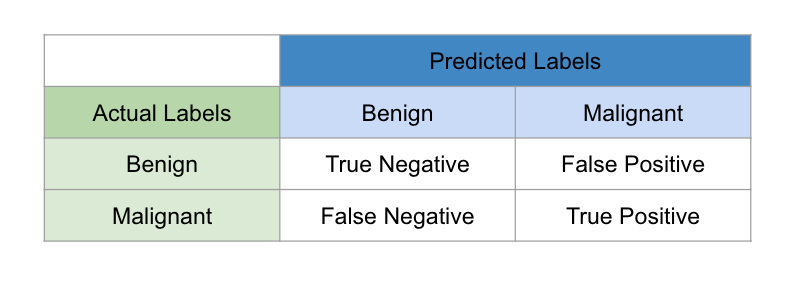

In [3]:
from IPython.display import Image
Image(filename='confusion_matrix.png') 

## The Model
Now, let's build a very simple model. Here by default sci-kit learn is using a threshold of 0.5. That means, if the probability of malignency is >=0.5, it is classified as malignant. Otherwise, it is classified as benign.

In [4]:
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
y_predicted = clf.predict(X_test)
print('Model Train Accuracy: ', round(clf.score(X_train, y_train)*100,2))
print('Model Test Accuracy: ', round(clf.score(X_test, y_test)*100,2))


Model Train Accuracy:  95.38
Model Test Accuracy:  95.61


/usr/local/Caskroom/miniconda/base/envs/anlp/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## The Results
Now, let's look at our resulting confusion matrix. The model has misclassified 5 examples, 4 as false negatives and 1 as a false positive. But remember, we just used the default setting of 0.5 as a our threshold for belonging to the positive class. This is something we can change, and may want to. 

In [5]:
# Confusion Matrix
print('Threshold: 0.5')
print('Confusion Matrix')
print(confusion_matrix(y_test, y_predicted))

Threshold: 0.5
Confusion Matrix
[[39  4]
 [ 1 70]]


## The True / False Positive Trade-Off
Suppose we raised the threshold to 0.95. Now, we would only be classifying instances as malignant if the model were very certain. This would result in **only classifying instances the model was very confident in**, thus reducing the number of false positives but also potentially missing some true positives as well. For example, suppose there were 2 instances, one true positive rated with 75% probability of being malignant and one a false positive with 35% probability of being malignent. 

With our new 95% threshold, the model would classify both the true positive and false positive examples as negatives. We can see below this model has no false positives but many more false negatives.

Now, let's think about the opposite. What if instead we set our threshold to 5%? Now we don't have any false negatives, but many more false positives

Clearly it is a balance between classifying all the true instances without having too many false positives!

Here is where the ROC curve comes in.

In [6]:
thresholds = [0.95, 0.05]
for threshold in thresholds:
    print('Threshold: ', threshold)
    print('Confusion Matrix')
    y_pred = (clf.predict_proba(X_test)[:, 1] > threshold).astype('float')
    print(confusion_matrix(y_test, y_pred))
    print('')

Threshold:  0.95
Confusion Matrix
[[43  0]
 [12 59]]

Threshold:  0.05
Confusion Matrix
[[37  6]
 [ 0 71]]



## The ROC Curve
Practically, it would be a pain to try each of these different thresholds. Ideally, we want to maximize the number of true positives but minimize the number of false positives. The ROC Curve visualizes these tradeoffs for every possible threshold. 

Suppose we had a truly random classifier, that like a coin flip assigned a value based on nothing. In this case, it would be just as likely to capture a true positive as a false positive. As such, it would be a diagonal line whose false positive rate increased equally with its false negative rate for every threshold. 

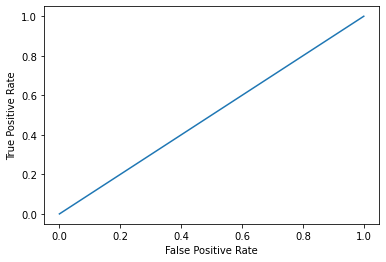

In [7]:
y_sample = [1,0,1,0]
y_random = [0,0,1,1]
fpr, tpr, thresholds = roc_curve(y_random, y_sample)
display = RocCurveDisplay(fpr=fpr, tpr=tpr)
display.plot()
plt.show()

If instead we had a perfect classifier, that properly classified every positive class as positive and every negative class as negative. In this case, the true positive rate would rise to 1 without the false positive rate rising.

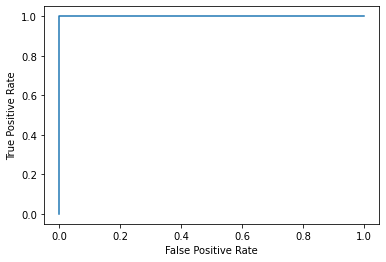

In [8]:
y_perfect =[1,0,1,0]
fpr, tpr, thresholds = roc_curve(y_perfect, y_sample)
display = RocCurveDisplay(fpr=fpr, tpr=tpr)
display.plot()
plt.show()

Thus, the closer our curve is up and to the left hand corner, the better the model is at differentiating true positives from false positives. Now, let's return to our example.

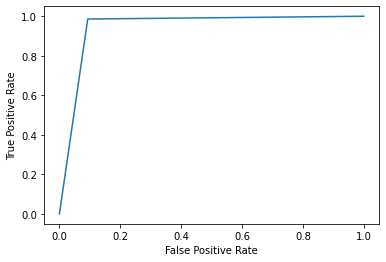

In [9]:
fpr, tpr, thresholds = roc_curve(y_test, y_predicted)
display = RocCurveDisplay(fpr=fpr, tpr=tpr)
display.plot()
plt.show()

## What other measurements might be helpful?

There are some other measurements that might be useful in assessing the strengths and weaknesses of our classifier. Read on!!!!

## DET Curve

The DET Curve (detection error tradeoff) is just like ROC curve but instead it plots the false negative rate against the false positive rate. We'd want both of these to be close to zero ideally, and so here closer to origin is better.

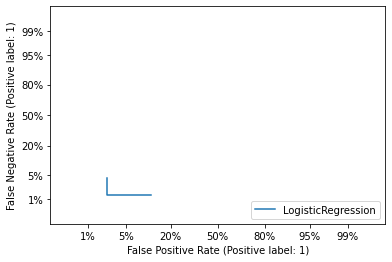

In [15]:
display = DetCurveDisplay.from_estimator(clf, X_test, y_test)

## AUC

One useful metric is the area under the curve, or AUC. This indicates the degree of separability between a negative and positive class. The higher the value, the higher the probability the model can separate a true positive from true negative. There should ideally be no overlap between the distribution of negatives under the threshold and positives above the threshold.

In [10]:
roc_auc = auc(fpr, tpr)
print(roc_auc)

0.9464461185718965


## Precision vs. Recall Curve

This gives a sense of the trade off between perfect precision and perfect recall at the various thresholds. Again, there might be situations where precision is more important than recall. Here, likely recall is more important than precision.

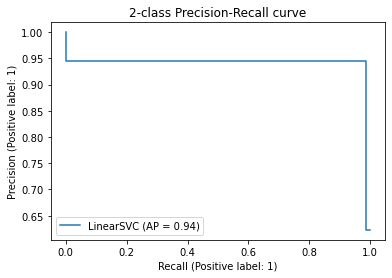

In [13]:
display = PrecisionRecallDisplay.from_predictions(y_test, y_predicted, name="LinearSVC")
_ = display.ax_.set_title("2-class Precision-Recall curve")

### Fin
That's it! Here are some additional resources I found helpful when creating this notebook and learning about these metrics
* https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc#:~:text=AUC%3A%20Area%20Under%20the%20ROC,to%20(1%2C1).
* https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5?gi=84716b0095ca